# Run training on Patient 25 from the Bruchovski data set

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("classic")
import seaborn as sns
%matplotlib inline
import sys
import os
from tqdm import tqdm
import subprocess
import json
%config Completer.use_jedi = False

sys.path.append("../utils")
from myUtils import mkdir, convert_ode_parameters, obtain_architecture, calc_critical_treatment_threshold
from LotkaVolterraModel import LotkaVolterraModel
from plotUtils import plot_simulation, plot_trainingPerformance

# Format plots
sns.set(style="white",
        font_scale=2.,
        font="Serif",
        rc={'figure.figsize':(12,6)})

In [58]:
# Notebook params
model_path = '../models'
results_path = './results/demo'
runFromScratch = True

model_name_1 = 'test_currSizeOnly_p25_step1'
model_name_2 = 'test_currSizeOnly_step2_weekly_trunc_Bruchovsky_adapted_fit2_id'

id_list = [f.name[len(model_name_2):] for f in os.scandir(model_path) if f.is_dir() and f.name.startswith(model_name_2)]
print(id_list)
max_epochs = {id: max([int(f.name.split('_')[0]) for f in os.scandir(os.path.join(model_path, model_name_2 + id)) if f.is_dir() and f.name.endswith(model_name_2 + id)])
              for id in id_list}
print(max_epochs)

n_epochs_list_1 = [100000]
n_epochs_list_2 = [150000]

['99', '25', '20', '12', '78', '85', '101']
{'99': 120000, '25': 120000, '20': 120000, '12': 120000, '78': 120000, '85': 120000, '101': 120000}


## Plot training results

In [85]:
n_replicates = 20
updating_interval = 7

### Plot training performance

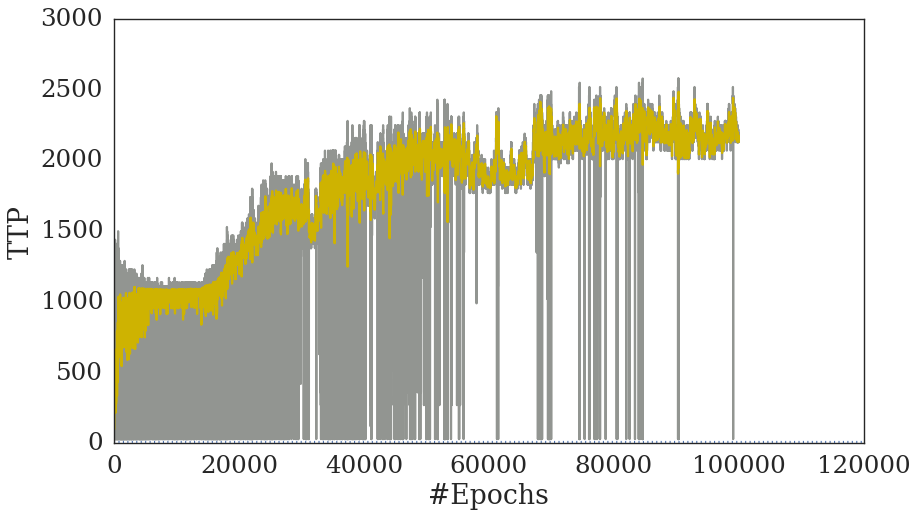

In [174]:
plot_trainingPerformance(model_id=model_name_1, model_path=model_path, var_to_plot='TTP',
                         lineYPos=10, figsize=(12,7))#, saveFig = True, outName = "../images/drl_performance/training_progression_%s" % model_id)
# plt.xticks([0, 100000, 200000])
# plt.xlabel("Epoch Number")
# plt.savefig("../images/drl_performance/training_progression_%s.png" % model_id)

### Evaluate on training patient (Patient 25)

In [43]:
trainingDataDf = pd.read_csv("../models/truncPatientsDf_bruchovsky.csv", index_col=0)
print(trainingDataDf.columns.values)

['n0' 'rS' 'rR' 'dS' 'dR' 'dD' 'k' 'D' 'theta' 'DMax' 'S0' 'R0'
 'PatientId']


In [71]:
# ODE params for model trained on patient 25
trainingDataDf = pd.read_csv("../models/trainingPatientsDf_bruchovsky.csv", index_col=0)
trainingDataDf['K'] = trainingDataDf['k']

# trainingDataDf['fR'] = trainingDataDf['R0'] / trainingDataDf['n0']
# trainingDataDf['cost'] = 1 - (trainingDataDf['rR'] / trainingDataDf['rS'])
# trainingDataDf['turnover'] = trainingDataDf['dS'] / trainingDataDf['rS']

trainingDataDf_25 = trainingDataDf[trainingDataDf.PatientId==25]
odeParamDic_25 = convert_ode_parameters(trainingDataDf_25['n0'].values[0],trainingDataDf_25['fR'].values[0],
                                     trainingDataDf_25['cost'].values[0],trainingDataDf_25['turnover'].values[0])

In [72]:
DRL_env = "/Users/galla/miniconda3/envs/DRL_env_tf15/python"  # Laptop
DRL_env = "/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python"  # Desktop

# read in architecture from params file.

for n_epochs in n_epochs_list_1:
    currModel_path = os.path.join("../models/",model_name_1, "%d_patients_%s"%(n_epochs, model_name_1))
    results_file_name = 'resultsDf_%s_%d_patients.csv'%(model_name_1,n_epochs)
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**odeParamDic_25,'PatientId':25}]).to_dict(), 
              'architecture_kws':obtain_architecture(model_name_1),
              'n_replicates':n_replicates, 'updating_interval':updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_p25.txt")}
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        with open("params/params_p25_%s.json"%(n_epochs), "w") as outfile:
            print("done")
            json.dump(argDic, outfile)
        command = DRL_env + " run_evaluation.py params/params_p25_%s.json"%(n_epochs)
        print(command)

        # Code to run the evaluation in the DRL environment
        # p = subprocess.run(command, capture_output=True, shell=True)
        # print(p.returncode, p.stdout, p.stderr)
        # if p.returncode==0:
        #     os.remove("params/params_%s.json"%(n_epochs))
        #     print("Run completed successfully")

        # Load results and process them
        dataDf_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_step1.ReplicateId.unique():
            ttp = dataDf_step1[dataDf_step1.ReplicateId==replicateId].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        ttpDf_step1 = pd.DataFrame(tmpList)
        ttpDf_step1.to_csv(os.path.join(results_path,"ttpDf_%s_p25_%d_patients.csv"%(model_name_1,n_epochs)))
    else:
        # Load results
        dataDf_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s__p25_%d_patients.csv"%(model_name_1,n_epochs)), index_col=0)


done
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_p25_100000.json


In [41]:
# Compute performance under rule of thumb
model = LotkaVolterraModel(method='RK45')
model.SetParams(**odeParamDic_25)
model.Simulate_AT(atThreshold=0.5, intervalLength=updating_interval, t_end=5000);
model.Trim(dt=1)

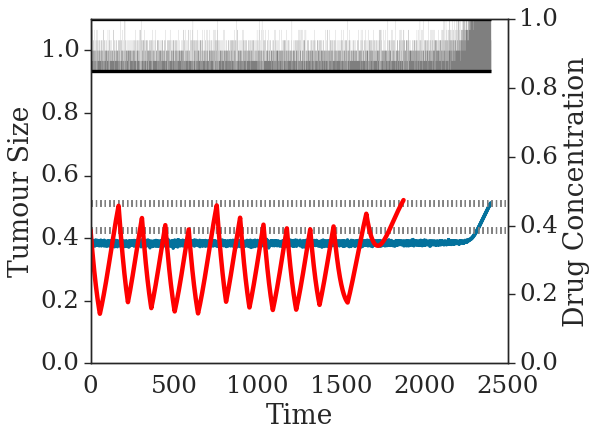

In [42]:
for n_epochs in n_epochs_list_1:
    results_file_name = 'resultsDf_%s_%d_patients.csv'%(model_name_1,n_epochs)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    # Plot average trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,6))
    plot_simulation(currDataDf, plotPops=False, lineplot_kws={'estimator':None, 'units':"ReplicateId"},
                    markInitialSize=True, markProgression=True, xlim=[0,2.5e3], ylim=[0,1.1], ax=ax)
    ax.plot(model.resultsDf.Time, model.resultsDf.TumourSize, lw=4, color='red')

### Analyse learned policy

In [14]:
tmpList = []
for n_epochs in n_epochs_list_1:
    results_file_name = 'resultsDf_%s_%d_patients.csv'%(model_name_1,n_epochs)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    currDataDf['TumourSize'] /= currDataDf['TumourSize'].iloc[0]
    currDataDf['n_epochs'] = n_epochs
    tmpList.append(currDataDf)
policyDf = pd.concat(tmpList)

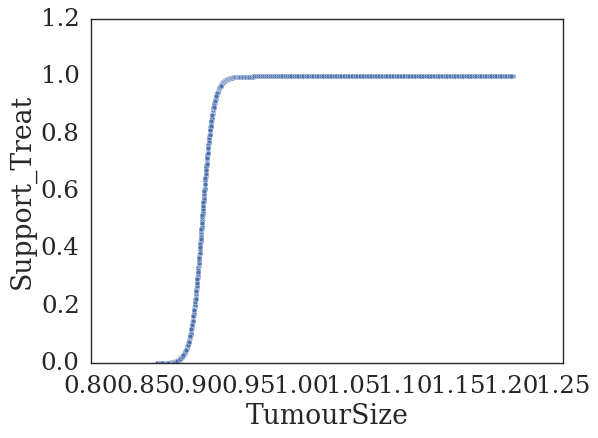

In [15]:
# Plot learned policies
fix, ax = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(x='TumourSize', y='Support_Treat', legend=False, data=policyDf, ax=ax) #, hue="n_epochs")
ax.set_ylim(0,1.2)
plt.tight_layout()
# plt.savefig("policy_comp_monthly.png")

## Consider second step of training

Typically generalises to multiple patients

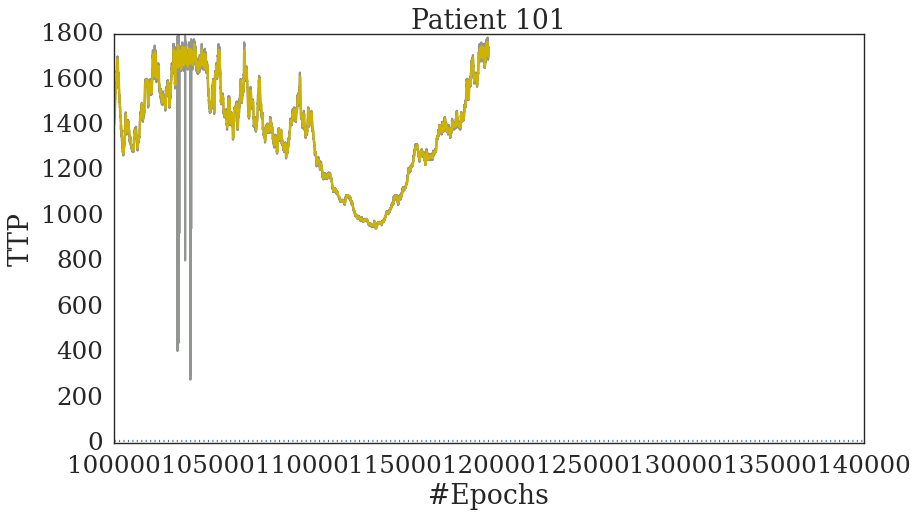

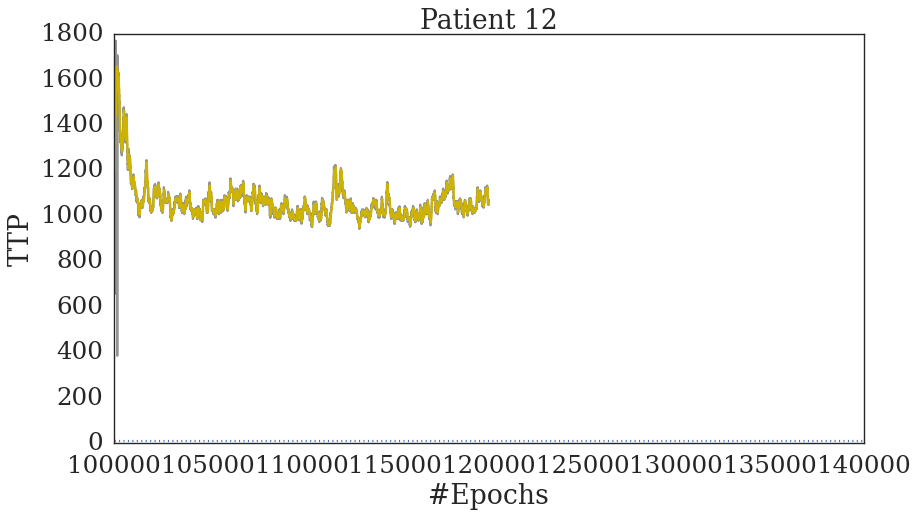

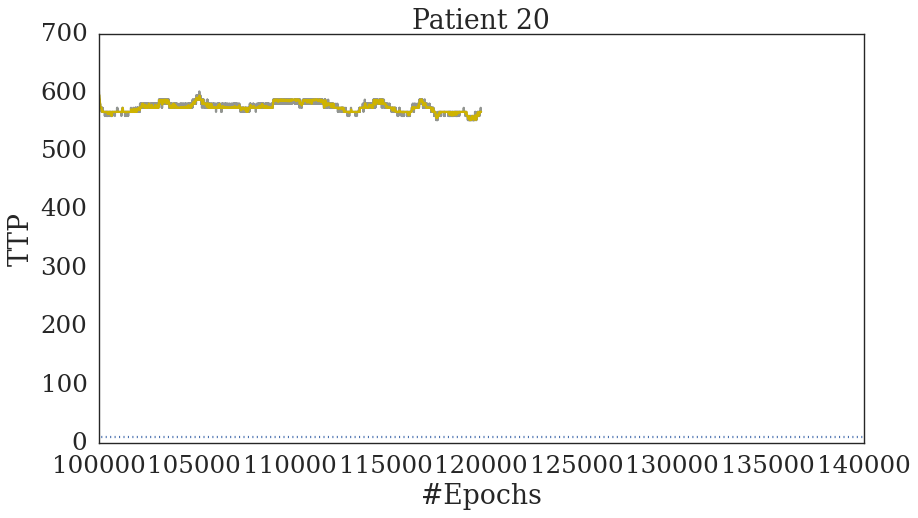

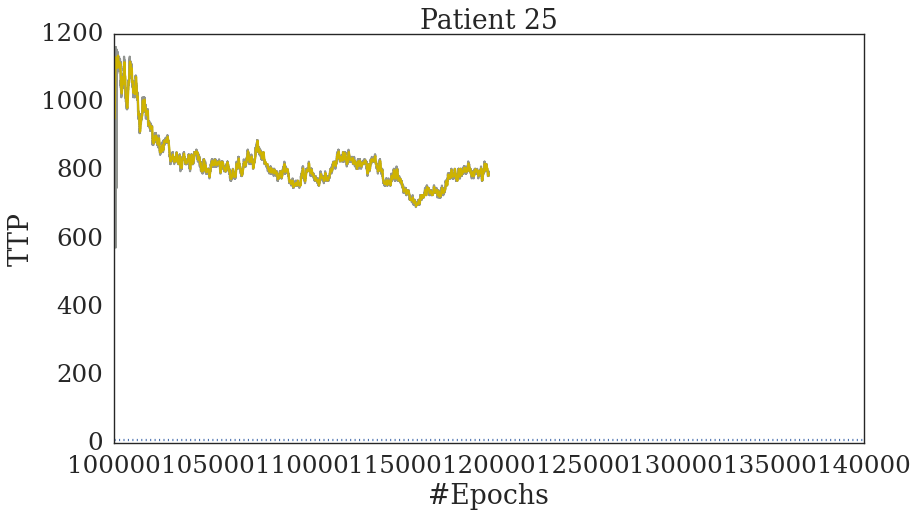

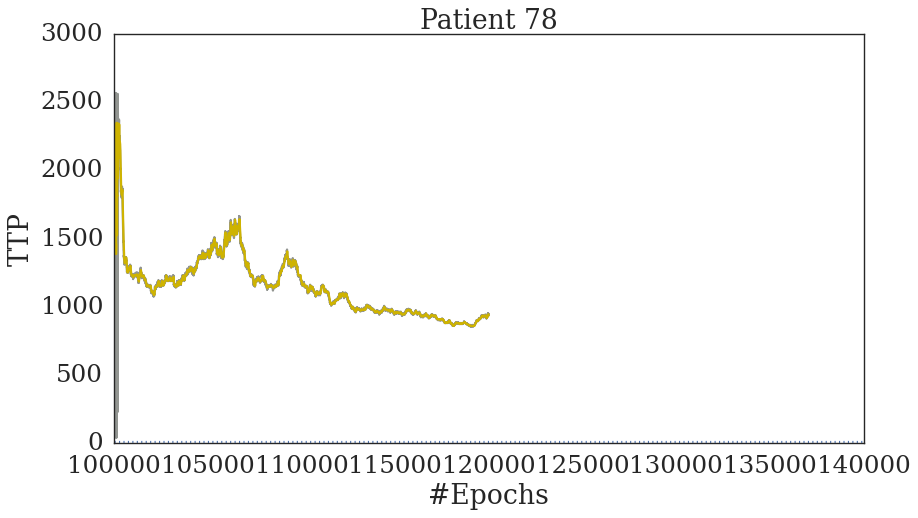

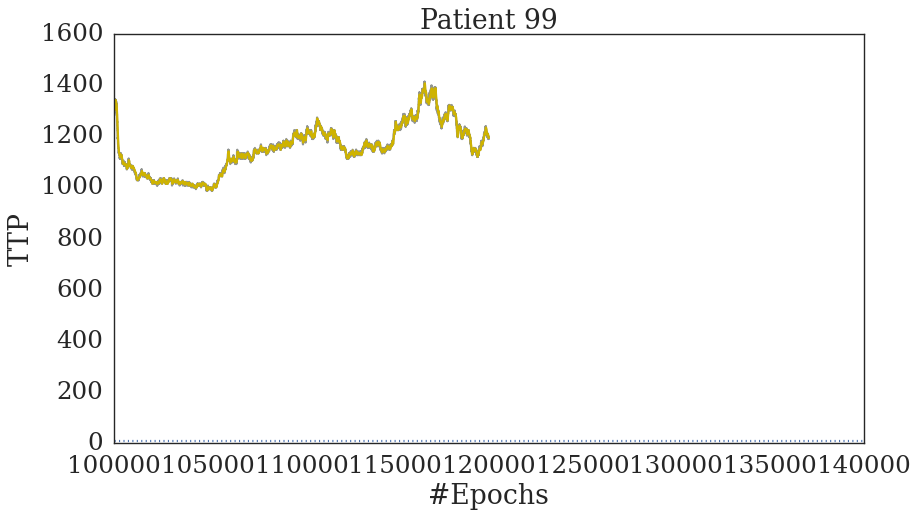

In [70]:
for id in sorted(id_list):
    try:
        plot_trainingPerformance(model_id=model_name_2 + id, model_path=model_path, var_to_plot='TTP', xlim = (100000, 140000), title = "Patient " + id,
                                 lineYPos=10, figsize=(12,7))#, saveFig = True, outName = "../images/drl_performance/training_progression_%s.png" % (model_name_2 + id))
        # plt.xlabel("Epoch Number")
    except:
        continue


In [86]:
odeParamDic = convert_ode_parameters(trainingDataDf['n0'].values[0],trainingDataDf['fR'].values[0],
                                     trainingDataDf['cost'].values[0],trainingDataDf['turnover'].values[0])
eval_df = trainingDataDf.rename(columns={'fR':'rFrac'}).apply(lambda row: pd.Series(convert_ode_parameters(**row)), axis=1)
eval_df['PatientId'] = trainingDataDf.apply(lambda row: int(trainingDataDf.loc[row.name]['PatientId']), axis=1)

eval_df['threshold'] = trainingDataDf['PatientId'].apply(lambda i: calc_critical_treatment_threshold(tau = updating_interval, prog=1.2, **trainingDataDf[trainingDataDf.PatientId==i].squeeze().to_dict()) / trainingDataDf[trainingDataDf.PatientId==i]['n0'].iloc[0])

# updating_interval = 7

In [87]:
print(updating_interval)

7


In [89]:
for id in id_list:
    n_epochs = max_epochs[id]
    currModel_path = os.path.join("../models/",model_name_2 + id, "%d_patients_%s"%(n_epochs, (model_name_2 + id)))
    results_file_name = 'resultsDf_%s_%d_patients.csv'%(model_name_2 + id,n_epochs)
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':eval_df[eval_df['PatientId']==int(id)].to_dict(),
              'architecture_kws':obtain_architecture(model_name_2 + id),
              'n_replicates':n_replicates, 'updating_interval':updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_all.txt")}
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        with open("params/params_all_%s%s.json"%(model_name_2 + id, n_epochs), "w") as outfile:
            json.dump(argDic, outfile)
            # print("Printed to JSON")
        command = DRL_env + " run_evaluation.py params/params_all_%s%s.json"%(model_name_2 + id, n_epochs)
        print(str(command))

        # Code to run the evaluation in the DRL environment
        # p = subprocess.run(command, capture_output=True)#, shell=True)
        # print(p.returncode, p.stdout, p.stderr, p.output)
        # if p.returncode==0:
        #     os.remove("params/params_%s.json"%(n_epochs))
        #     print("Run completed successfully")

        # Load results and process them
        dataDf_step2 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # dataDf_step2id = dataDf_step2[dataDf_step2['PatientId']==id]
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_step2.ReplicateId.unique():
            ttp = dataDf_step2[(dataDf_step2.ReplicateId==replicateId) & (dataDf_step2.PatientId==int(id))].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp, "PatientId":id})
        ttpDf_step2 = pd.DataFrame(tmpList)
        ttpDf_step2.to_csv(os.path.join(results_path,"ttpDf_%s_all_%d_patients.csv"%(model_name_2 + id, n_epochs)))
    else:
        # Load results
        dataDf_step2 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_step2 = pd.read_csv(os.path.join(results_path,"ttpDf_%s__all_%d_patients.csv"%(model_name_2 + id, n_epochs)), index_col=0)
        
# https://stackoverflow.com/questions/72663449/running-script-in-conda-environment-from-within-script-in-another-conda-environm
# https://github.com/conda/conda/issues/9587  

# !source activate DRL_env_tf15 && python run_evaluation.py params/params_all_200000.json


/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_all_test_currSizeOnly_step2_weekly_trunc_Bruchovsky_adapted_fit2_id99120000.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_all_test_currSizeOnly_step2_weekly_trunc_Bruchovsky_adapted_fit2_id25120000.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_all_test_currSizeOnly_step2_weekly_trunc_Bruchovsky_adapted_fit2_id20120000.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_all_test_currSizeOnly_step2_weekly_trunc_Bruchovsky_adapted_fit2_id12120000.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_all_test_currSizeOnly_step2_weekly_trunc_Bruchovsky_adapted_fit2_id78120000.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py params/params_all_test_currSizeOnly_step2_weekly_trunc_Bruchovsky_adapted_fit2_id

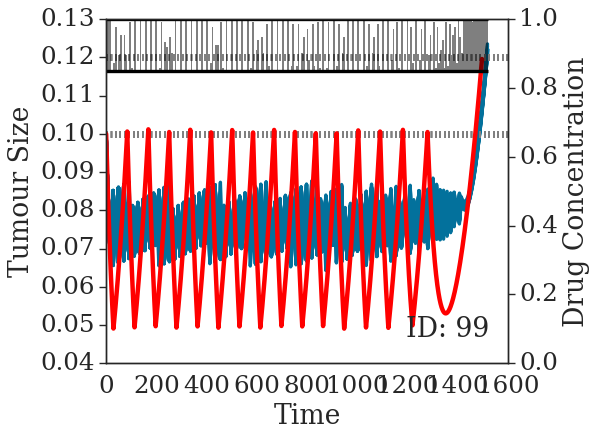

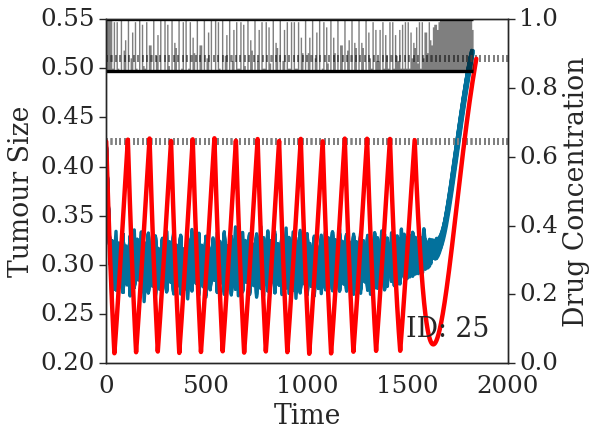

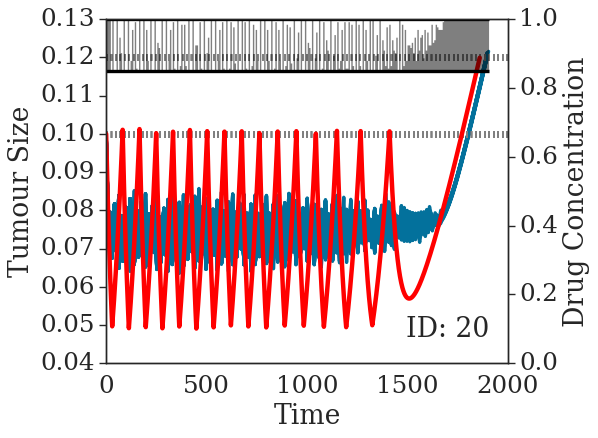

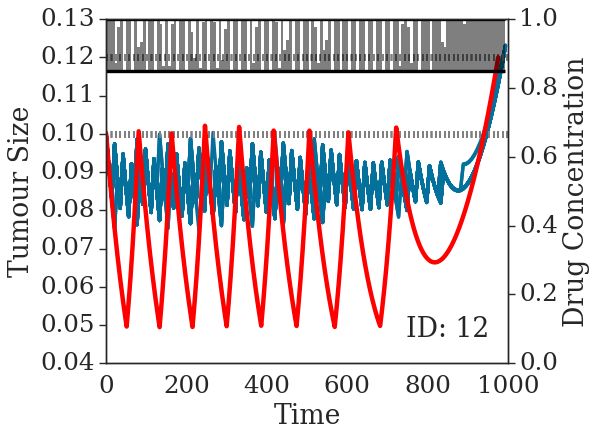

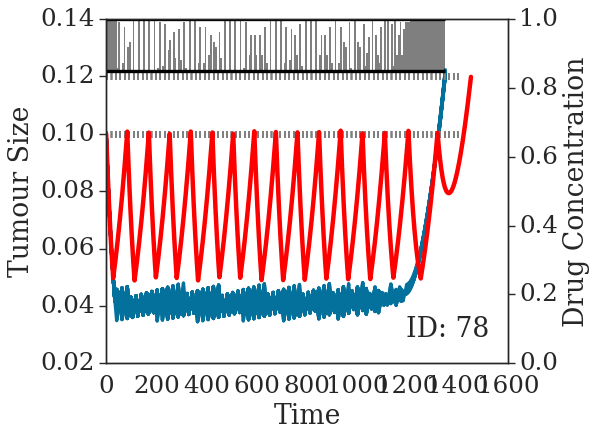

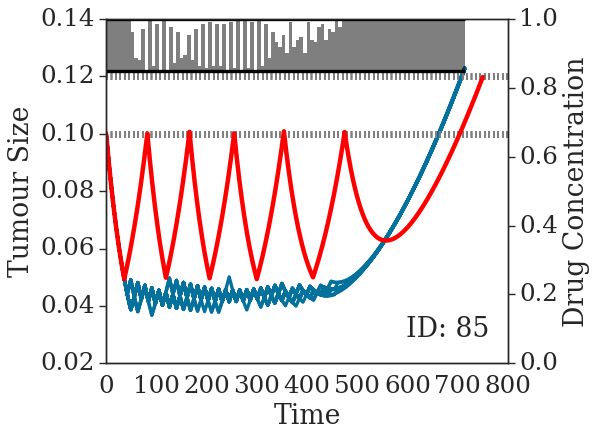

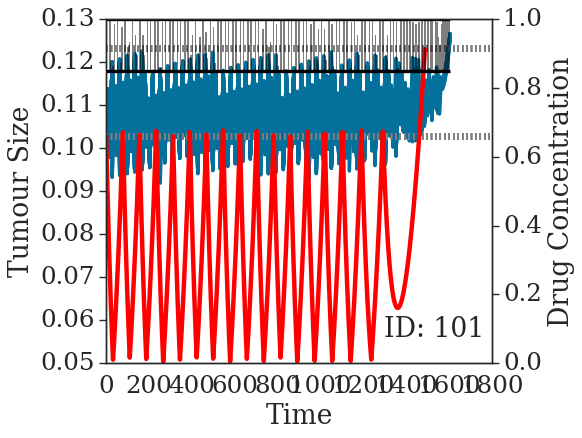

In [90]:
for id in id_list:
    trainingDataDf_id = trainingDataDf[trainingDataDf.PatientId==int(id)]
    odeParamDic_id = convert_ode_parameters(trainingDataDf_id['n0'].values[0],trainingDataDf_id['fR'].values[0],
                                         trainingDataDf_id['cost'].values[0],trainingDataDf_id['turnover'].values[0])
    model_id = LotkaVolterraModel(method='RK45'); model_id.SetParams(**odeParamDic_id)
    model_id.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=5000, solver_kws = {'dt':1}); model_id.Trim(dt=1)
    
    results_file_name = 'resultsDf_%s_%d_patients.csv'%(model_name_2 + id,max_epochs[id])
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    # Plot average trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,6))
    plot_simulation(currDataDf[currDataDf['PatientId'] == int(id)], plotPops=False, lineplot_kws={'estimator':None, 'units':"ReplicateId"},
                    markInitialSize=True, markProgression=True, ax=ax)
    ax.plot(model_id.resultsDf.Time, model_id.resultsDf.TumourSize, lw=4, color='red')
    ax.text(0.85, 0.1, 'ID: %s'%id, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
    # plt.savefig("weekly_perf.png")

In [91]:
tmpList = []
for id in id_list:
    for n_epochs in [max_epochs[id]]: #n_epochs_list_2:
        results_file_name = 'resultsDf_%s_%d_patients.csv'%(model_name_2+id,n_epochs)
        currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
        currDataDf['TumourSize'] = currDataDf.apply(lambda row: row['TumourSize'] / trainingDataDf[trainingDataDf.PatientId==row['PatientId']]['n0'].values[0], axis=1)
        currDataDf['n_epochs'] = n_epochs
        tmpList.append(currDataDf)
policyDf = pd.concat(tmpList)

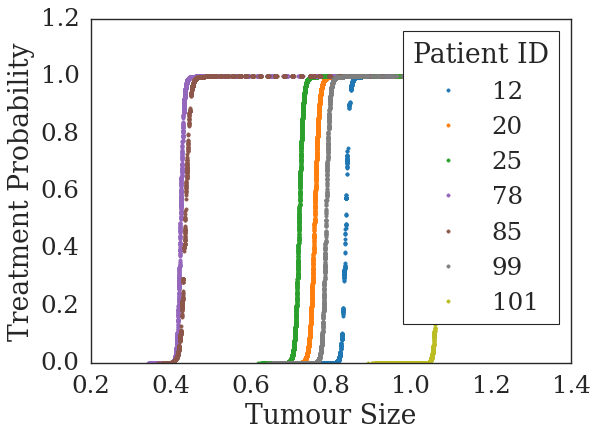

In [92]:
# Plot learned policies

# #alt df
# trainingDataDf = pd.read_csv("patients/Bruchovsky_et_al/Prog_truncated_fits/5params_Capacity/fitPatientsDf_all.csv", index_col=0)
# trainingDataDf['K'] = trainingDataDf['k']

# updating_interval = 30
n = len(policyDf['PatientId'].unique())
cols = [matplotlib.cm.get_cmap('tab10')(i/n) for i in range(n)]

fix, ax = plt.subplots(1,1,figsize=(8,6))
for i, id in enumerate(np.sort(policyDf['PatientId'].unique())):
    n0 = trainingDataDf[trainingDataDf.PatientId==id]['n0'].values[0]
    ax.plot(policyDf[policyDf['PatientId']==id]['TumourSize'], policyDf[policyDf['PatientId']==id]['Support_Treat'], 
             marker = '.', linestyle = '', label = id, color = cols[i])
    plt.plot(calc_critical_treatment_threshold(tau = updating_interval, prog=1.2, **trainingDataDf[trainingDataDf.PatientId==id].squeeze().to_dict()) / n0, 1.1,
             marker = 'X', markersize = 8, color = cols[i])
    # print(calc_critical_treatment_threshold(tau = 28, **trainingDataDf[trainingDataDf.PatientId==id].squeeze().to_dict()) / n0)
ax.set_ylim(0,1.2); ax.set_ylabel('Treatment Probability'); ax.set_xlabel('Tumour Size'); # ax.set_xlim(0, 1.5)
plt.legend(numpoints=1, title = 'Patient ID'); 
plt.tight_layout(); plt.savefig("../images/multiple_patients/policy_%s_full.png"%(model_name_2))

In [93]:
from LotkaVolterraModel import LotkaVolterraModel

def calc_ttp(ID, params_path = "../models/trainingPatientsDf_bruchovsky.csv", method = 'ROT'):
    # Calculate analytic TTP using either Rule Of Thumb (ROT) or Maximum Tolerated Dose (MTD) strategies
    model = LotkaVolterraModel(method='RK45')
    paramDic = {**model.GetParams(params_path, "number", id=ID)}
    model.SetParams(**paramDic)
    if method == 'ROT':
        model.Simulate_AT(atThreshold=0.5, intervalLength=updating_interval, t_end=5000)
    elif method == 'MTD':
        model.Simulate([[0, 4000, 1]])
    else:
        raise ValueError('Unknown treatment protocol - should be either \'ROT\' or \'MTD\'')
    model.Trim(dt=1)
    return model.ttp

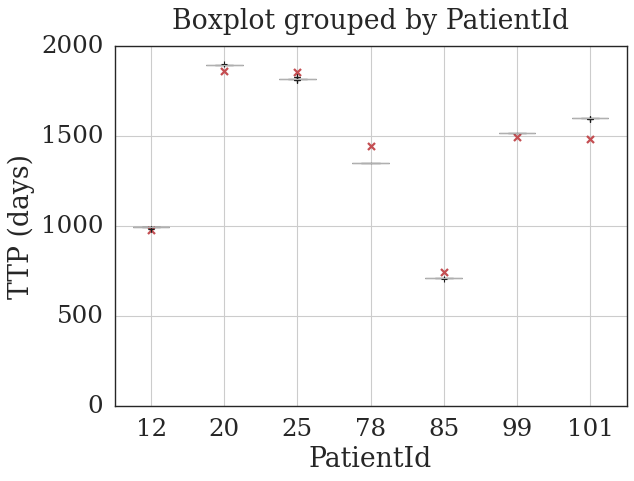

In [94]:
tmpList = []
for id in id_list:
    results_file_name = 'ttpDf_%s_all_%d_patients.csv'%(model_name_2 + id,max_epochs[id])
    finDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    tmpList.append(finDataDf)
    
combDf = pd.concat(tmpList)

# Plot average trajectories
fix, ax = plt.subplots(1,1,figsize=(8,6))
combDf.boxplot(column='TTP', by='PatientId', ax=ax);
ax.set_title(''); ax.set_ylabel('TTP (days)'); ax.set_ylim(bottom=0)
    
comp_vals = [calc_ttp(i) for i in sorted(list(combDf.PatientId.unique()))]
ax.scatter(range(1, 1+len(comp_vals)), comp_vals, color='r', marker='x', linewidth=2, s=40);